<a href="https://colab.research.google.com/github/TheRyidGilani/Brain_Tumor_Image_Segmentation/blob/main/Ryid_Gilani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brain Tumor Segmentation Project for EE8204**

## **Setup Environment and Parameters**

The script below sets up a deep learning environment for brain tumor segmentation using convolutional neural networks in TensorFlow.

It includes the initial steps of mounting Google Drive to access the dataset, installing necessary libraries, and setting up paths and hyperparameters for model training. The code also includes essential functionality for data handling, model creation, and the implementation of callbacks for monitoring the training process.

In [ ]:
# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install Libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, BatchNormalization, Activation, Input, MaxPool2D, Conv2DTranspose, Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau, TensorBoard
from keras.optimizers import Adam

# Seeding
os.environ["PYTHONHASHSEED"] = str(123)
np.random.seed(123)
tf.random.set_seed(123)

# Hyperparameters
batch_size = 16
lr = 0.0001
epochs = 20
height = 256
width = 256
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "log.csv")

# Path to dataset
dataset_path = os.path.join("/content/drive/MyDrive", "Brain Tumor Dataset")

# Create a folder, if needed
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print("Directory created")
    else:
        print("Directory already exists")
create_dir(dataset_path)

Directory already exists


## **UNET Architecture**

This segment of code shown below, defines the architecture of a U-Net model.

The U-Net architecture is structured with an encoder (downsampling) path, a bottleneck, and a decoder (upsampling) path, which includes skip connections to help preserve spatial hierarchies between layers.

The convolution_block function constructs convolutional layers with batch normalization and ReLU activation. encoder_block and decoder_block are designed to progressively downsample and then upsample the feature maps while integrating skip connections for detailed feature reconstruction.

The final architecture is compiled into a model that maps input images to their corresponding segmented outputs, making it suitable for tasks like brain tumor segmentation.

In [ ]:
# Convolution Block
def convolution_block(inputs, number_of_filters):
  conv = Conv2D(number_of_filters, 3, padding ='same')(inputs)
  conv = BatchNormalization()(conv)
  conv = Activation("relu")(conv)
  conv = Conv2D(number_of_filters, 3, padding ='same')(conv)
  conv = BatchNormalization()(conv)
  conv = Activation("relu")(conv)
  return conv

# Encoder Block
def encoder_block(inputs, number_of_filters):
  conv = convolution_block(inputs, number_of_filters)
  pool = MaxPool2D((2,2))(conv)
  return conv, pool

# Decoder Block
def decoder_block(inputs, skip_connections, number_of_filters):
  deconv = Conv2DTranspose(number_of_filters, 2, strides = 2, padding = 'same')(inputs)
  deconv = Concatenate()([deconv, skip_connections])
  deconv = convolution_block(deconv, number_of_filters)
  return deconv

# UNET Model
def unet(input_shape):
  input_layer = Input(input_shape)
  enc_conv1, enc_pool1 = encoder_block(input_layer, 64)
  enc_conv2, enc_pool2 = encoder_block(enc_pool1, 128)
  enc_conv3, enc_pool3 = encoder_block(enc_pool2, 256)
  enc_conv4, enc_pool4 = encoder_block(enc_pool3, 512)

  bottleneck = convolution_block(enc_pool4, 1024)

  dec_conv1 = decoder_block(bottleneck, enc_conv4, 512)
  dec_conv2 = decoder_block(dec_conv1, enc_conv3, 256)
  dec_conv3 = decoder_block(dec_conv2, enc_conv2, 128)
  dec_conv4 = decoder_block(dec_conv3, enc_conv1, 64)

  output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(dec_conv4)
  model = Model(input_layer, output_layer, name="UNET")
  return model

## **Dataset Pipeline**

The code below, defines functions for preparing and processing a dataset of images and masks for training a neural network model.

The load_dataset function organizes the data into training, validation, and testing sets, ensuring a balanced distribution according to specified ratios. The read_images and read_masks functions handle the reading, resizing, and normalization of the images and masks respectively, ensuring they are correctly formatted for model input. The tf_parse function integrates these preprocessing steps into TensorFlow's data pipeline, allowing for efficient data manipulation within the model's computation graph.

Finally, the tf_dataset function creates a TensorFlow Dataset object that batches, processes, and prefetches the data, optimizing it for training the model in a streamlined and efficient manner.

In [ ]:
# Function to load the dataset and split it into training, validation, and test sets.
def load_dataset(path, split=(0.6, 0.2, 0.2)):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))
    train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=split[2], random_state=42)
    train_images, valid_images, train_masks, valid_masks = train_test_split(train_images, train_masks, test_size=split[1]/(1-split[2]), random_state=42)
    return (train_images, train_masks), (valid_images, valid_masks), (test_images, test_masks)

# Function to read the IMAGES and resize them.
def read_images(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (width, height))
    image = image / 255.0
    image = image.astype(np.float32)
    return image

# Function to read the MASKS and resize them.
def read_masks(path):
    path = path.decode()
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (width, height))
    mask = mask / 255.0
    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return mask

# Function to parse the images and masks.
def tf_parse(image, mask):
    def _parse(image, mask):
        image = read_images(image)
        mask = read_masks(mask)
        return image, mask

    image, mask = tf.numpy_function(_parse, [image, mask], [tf.float32, tf.float32])
    image.set_shape([height, width, 3])
    mask.set_shape([height, width, 1])
    return image, mask

# Function to create a dataset from the images and masks.
def tf_dataset(X, Y, batch=batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


## **Training**

This section of the code is focused on the end-to-end setup and execution of training a U-Net model for image segmentation.

Initially, the dataset, located at a specified path, is loaded and split into training, validation, and test subsets using a predefined function that ensures appropriate distribution. TensorFlow dataset objects for the training and validation sets are then created, which efficiently handle batch processing and prefetching to optimize training throughput.

Training is facilitated by a series of callbacks including model checkpointing for saving the best model, learning rate reduction on plateaus to improve training dynamics, CSV logging for tracking training progress, and early stopping to prevent overfitting

In [ ]:
# Load the dataset and split it into training, validation, and test sets
(train_images, train_masks), (valid_images, valid_masks), (test_images, test_masks) = load_dataset(dataset_path)

# Create TensorFlow datasets for training and validation
train_dataset = tf_dataset(train_images, train_masks, batch=batch_size)
valid_dataset = tf_dataset(valid_images, valid_masks, batch=batch_size)

# Define the U-Net model architecture
model = unet((height, width, 3))

# Compile the model with Adam optimizer and binary cross-entropy loss
opt = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

# Define callbacks for training
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),  # Log training metrics to a CSV file
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
]

# Train the model
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/20
115/115 [==============================] - ETA: 0s - loss: 0.2136 - accuracy: 0.9633
Epoch 1: val_loss improved from inf to 0.38115, saving model to files/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


115/115 [==============================] - 257s 2s/step - loss: 0.2136 - accuracy: 0.9633 - val_loss: 0.3812 - val_accuracy: 0.9823 - lr: 1.0000e-04
Epoch 2/20
115/115 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.9835
Epoch 2: val_loss improved from 0.38115 to 0.25374, saving model to files/model.h5
115/115 [==============================] - 33s 285ms/step - loss: 0.1140 - accuracy: 0.9835 - val_loss: 0.2537 - val_accuracy: 0.9823 - lr: 1.0000e-04
Epoch 3/20
115/115 [==============================] - ETA: 0s - loss: 0.0923 - accuracy: 0.9861
Epoch 3: val_loss improved from 0.25374 to 0.20590, saving model to files/model.h5
115/115 [==============================] - 32s 279ms/step - loss: 0.0923 - accuracy: 0.9861 - val_loss: 0.2059 - val_accuracy: 0.9536 - lr: 1.0000e-04
Epoch 4/20
115/115 [==============================] - ETA: 0s - loss: 0.0775 - accuracy: 0.9876
Epoch 4: val_loss improved from 0.20590 to 0.10669, saving model to files/model.h5
115/115 [===

The next code snippet is for visualizing the training process of a machine learning model, specifically focusing on plotting the loss and accuracy metrics over epochs. By setting the plot style to 'ggplot', it ensures that the graphs are visually appealing and clear. Two separate plots are generated:

Loss Plot: This displays the change in training and validation loss during the model training.

Accuracy Plot: This graph shows the training and validation accuracy.

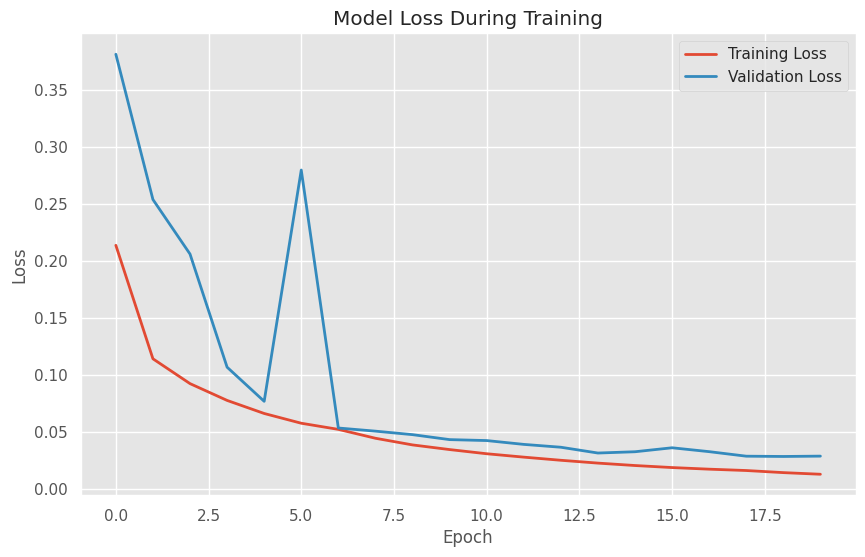

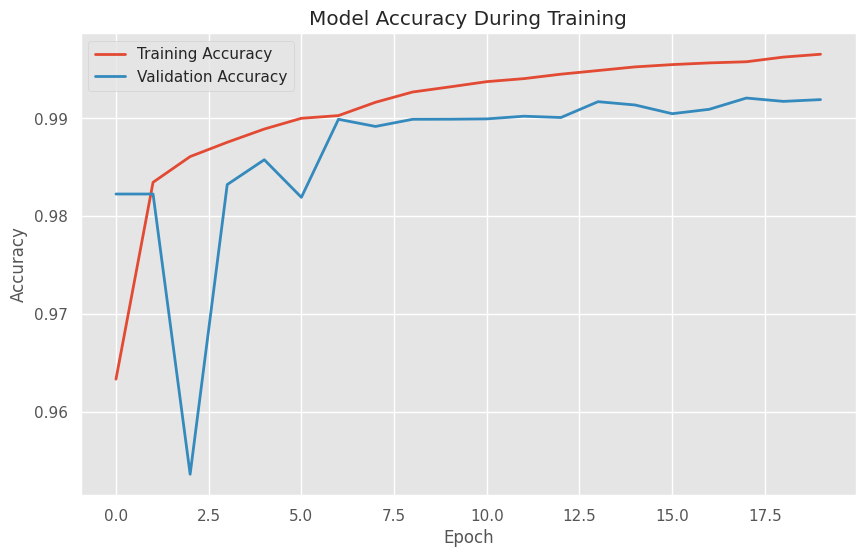

In [ ]:
# Setting a plot style
plt.style.use('ggplot')

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_loss.png')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_accuracy.png')
plt.show()

# **Testing**

 The code below sets up a directory to store the results.

In [ ]:
#Create a Folder to Save the Results
create_dir(os.path.join("files", "Results"))

Directory already exists


The script then processes each image in the test set: it reads and preprocesses both the image and its corresponding mask, predicts the mask using the trained model, and constructs a visualization that combines the original image with the true and predicted masks. This combined image is saved to a designated directory. Besides generating visual outputs, the code calculates several key performance metrics for each prediction—F1 score, Jaccard index, recall, and precision—and logs these metrics for each image. Finally, it averages these metrics across all images to evaluate overall model performance and saves both the individual results and the averages to a CSV file.

In [ ]:
# Function to save the visual results of predictions
def save_results(image, mask, y_pred, save_image_path):
    # Expand dimensions of mask and predicted mask
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

    # Multiply predicted mask by 255 to convert to uint8
    y_pred_uint8 = y_pred * 255

    # Create a white line separator
    line = np.ones((height, 10, 3)) * 255

    # Concatenate original image, line, mask, line, and predicted mask horizontally
    cat_images = np.concatenate([image, line, mask, line, y_pred_uint8], axis=1)

    # Add text annotations
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_color = (255, 255, 255)  # White color
    thickness = 2
    cv2.putText(cat_images, 'Original Image', (10, 30), font, font_scale, font_color, thickness)
    cv2.putText(cat_images, 'Actual Mask', (image.shape[1] + line.shape[1] + 10, 30), font, font_scale, font_color, thickness)
    cv2.putText(cat_images, 'Predicted Mask', (image.shape[1] + 2 * line.shape[1] + mask.shape[1] + 10, 30), font, font_scale, font_color, thickness)

    # Save the concatenated image to the specified path
    save_image_path = os.path.join("files", save_image_path)  # Adjust the path here
    cv2.imwrite(save_image_path, cat_images)

# List to store evaluation scores for each image
SCORE = []

# Loop through each pair of test image and mask paths
for x, y in tqdm(zip(test_images, test_masks), total=len(test_masks)):
    name = x.split("/")[-1]

    # Read and preprocess the test image
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (width, height))
    x = image/255.0
    x = np.expand_dims(x, axis=0)

    # Read and preprocess the corresponding mask
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (width, height))

    # Predict the mask using the model
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    # Define the path to save the visual results
    save_image_path = os.path.join("Results", name)

    # Save the visual results
    save_results(image, mask, y_pred, save_image_path)

    # Prepare the true mask and predicted mask for evaluation
    mask = mask/255.0
    mask = (mask > 0.5).astype(np.int32).flatten()
    y_pred = y_pred.flatten()

    # Calculate evaluation metrics
    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)

    # Append the metrics for this image to the SCORE list
    SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

# Calculate the average of each metric across all tested images
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"F1: {score[0]:0.5f}")
print(f"Jaccard: {score[1]:0.5f}")
print(f"Recall: {score[2]:0.5f}")
print(f"Precision: {score[3]:0.5f}")

# Save the individual image scores and their averages to a CSV file
df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score.csv")

100%|██████████| 613/613 [07:02<00:00,  1.45it/s]

F1: 0.72161
Jaccard: 0.63188
Recall: 0.68899
Precision: 0.82793


The final code snippet is designed to visually inspect the results of a segmentation model by displaying the first three images from a results directory. It starts by specifying the path where result images are stored and loads a corresponding CSV file containing performance metrics for each image. The code identifies the filenames of the first three images listed in the score CSV, constructs their paths from the results folder, and prepares a plot for each image. These images, which include original images, actual masks, and predicted masks, are then displayed in a figure with each image in its subplot, providing an immediate visual assessment of the model's accuracy on individual examples.

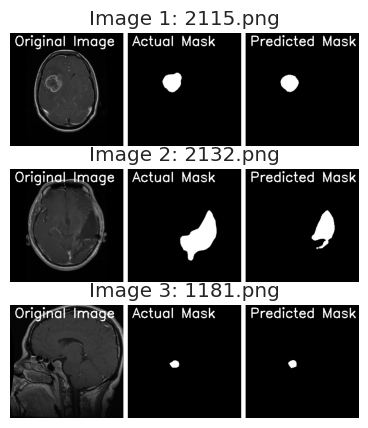

In [ ]:
# Specify the path to your results folder containing the images
results_folder = '/content/files/Results'

# Load scores from the CSV file
score_df = pd.read_csv('/content/files/score.csv')

# Get only the filenames of the first three entries in the score DataFrame
first_three_files = score_df['Image'].head(3).tolist()

# Find and load only these specific image files from the results folder
image_files = [os.path.join(results_folder, file) for file in os.listdir(results_folder) if file.endswith('.png') and file in first_three_files]

# Set up the figure for displaying images
plt.figure(figsize=(15, 5))

# Loop through the three image files and display each
for i, file_path in enumerate(image_files, start=1):
    img = plt.imread(file_path)
    plt.subplot(3, 1, i)
    plt.imshow(img)
    plt.title(f"Image {i}: {os.path.basename(file_path)}")
    plt.axis('off')

# Show first 3 predictions
plt.show()

In [ ]:
# Display the scores for the same images
score_df[score_df['Image'].isin(first_three_files)]

,Unnamed: 0,Image,F1,Jaccard,Recall,Precision
0,0,2115.png,0.906553,0.829078,0.830846,0.997440
1,1,1181.png,0.916667,0.846154,0.883212,0.952756
2,2,2132.png,0.649029,0.480417,0.496699,0.936126
